# Data Preparation

On this notebook, the data generated on the process of Feature Engineering passes through a final step of preparation before it is fed to the Machine Learning model proposed on this work.

## 1. Packages

In [6]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns 
sns.set_style('darkgrid')

import datetime
from sklearn.preprocessing import RobustScaler,MinMaxScaler,LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from boruta import BorutaPy
import pickle

## 2. Data Reading

In [7]:
data = pd.read_pickle('../Data/data_engineered.pkl')

In [8]:
data.head()

,store,day_of_week,date,sales,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week
0,1,5,2015-07-31,5263,1,regular_day,1,c,basic,1270.0,9,2008,0,31,2015,0,2015,7,31,31,2015-30,2008-09-01,84,2015-07-27,0
1,2,5,2015-07-31,6064,1,regular_day,1,a,basic,570.0,11,2007,1,13,2010,1,2015,7,31,31,2015-30,2007-11-01,94,2010-03-22,279
2,3,5,2015-07-31,8314,1,regular_day,1,a,basic,14130.0,12,2006,1,14,2011,1,2015,7,31,31,2015-30,2006-12-01,105,2011-03-28,226
3,4,5,2015-07-31,13995,1,regular_day,1,c,extended,620.0,9,2009,0,31,2015,0,2015,7,31,31,2015-30,2009-09-01,71,2015-07-27,0
4,5,5,2015-07-31,4822,1,regular_day,1,a,basic,29910.0,4,2015,0,31,2015,0,2015,7,31,31,2015-30,2015-04-01,4,2015-07-27,0


## 3. Data Preparation

### 3.1 Normalization

No Numerical Feature presented a Normal Distribution, so Normalization processess were not needed.

### 3.2 Rescaling

We start the Rescaling process applying a Robust Scaler to variables that contains some Outliers.

In [9]:
rs = RobustScaler()

data['competition_distance'] = rs.fit_transform(data[['competition_distance']].values)
pickle.dump(rs, open('../Parameter/competition_distance_scaler.pkl','wb'))

data['competition_time_month'] = rs.fit_transform(data[['competition_time_month']].values)
pickle.dump(rs, open('../Parameter/competition_time_month_scaler.pkl','wb'))

Then, for the features that presented a Non-Normal Distribution, a Min-Max Scaler is applied.

In [10]:
mms = MinMaxScaler()

data['promo_time_week'] = mms.fit_transform(data[['promo_time_week']].values)
pickle.dump(mms, open('../Parameter/promo_time_week_scaler.pkl','wb'))

data['year'] = mms.fit_transform(data[['year']].values)
pickle.dump(mms, open('../Parameter/year_scaler.pkl','wb'))

### 3.3 Transformations

On this section, some feature transformations are proposed to adapt the dataset to the modelling process. We start by first converting the "State Holiday" column to a One-Hot Encoding format.

In [11]:
data = pd.get_dummies(data, prefix=['state_holiday'], columns=['state_holiday'])

For the "Store Type" column, which is a originally encoded column, a Label Encoder is applied.

In [12]:
le = LabelEncoder()
data['store_type'] = le.fit_transform(data['store_type'])
pickle.dump(le,open('../Parameter/store_type_scaler.pkl','wb'))

The "Assortment" column, as seen before, presents an ordinal order, from basic to extended types. Because of this, a Ordinal Enconding is applied.

In [13]:
assortment_dict = {'basic' : 1, 'extra' : 2, 'extended' : 3}
data['assortment'] = data['assortment'].map(assortment_dict)

The Target Variable, Sales, present a Skewed Distribution with a Long Tail. To transform this feature to a more Normal Distribution, a Log Transformation is applied.

In [23]:
data['sales'] = np.log1p(data['sales'])

Text(0.5, 1.0, 'Sales after Log Transformation')

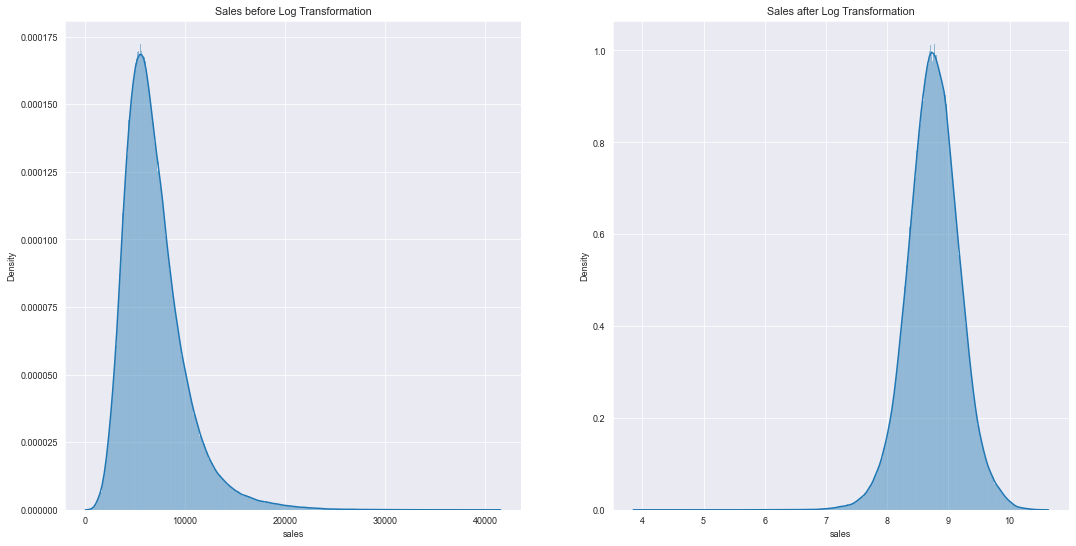

In [15]:
plt.subplot(1,2,1)
sns.histplot(data['sales'],stat='density',kde=True)
plt.title('Sales Before Log Transformation')

data['sales'] = np.log1p(data['sales'])

plt.subplot(1,2,2)
sns.histplot(data['sales'],stat='density',kde=True)
plt.title('Sales After Log Transformation')

Finally, the columns related to temporal features are submitted to a Sine-Cossine transformation. This process is used to give the data the cyclical nature of time, be it on weeks, months, years and so on.

In [25]:
data['day_sin'] = data['day'].apply(lambda x: np.sin(x*(2.*np.pi/30)))
data['day_cos'] = data['day'].apply(lambda x: np.cos(x*(2.*np.pi/30)))

data['day_of_week_sin'] = data['day_of_week'].apply(lambda x: np.sin(x*(2.*np.pi/7)))
data['day_of_week_cos'] = data['day_of_week'].apply(lambda x: np.cos(x*(2.*np.pi/7)))

data['week_of_year_sin'] = data['week_of_year'].apply(lambda x: np.sin(x*(2.*np.pi/52)))
data['week_of_year_cos'] = data['week_of_year'].apply(lambda x: np.cos(x*(2.*np.pi/52)))

data['month_sin'] = data['month'].apply(lambda x: np.sin(x*(2.*np.pi/12)))
data['month_cos'] = data['month'].apply(lambda x: np.cos(x*(2.*np.pi/12)))

In [26]:
data.head()

,store,day_of_week,date,sales,promo,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week,state_holiday_christmas,state_holiday_easter_holiday,state_holiday_public_holiday,state_holiday_regular_day,day_sin,day_cos,day_of_week_sin,day_of_week_cos,week_of_year_sin,week_of_year_cos,month_sin,month_cos
0,1,5,2015-07-31,8.568646,1,1,2,1,-0.170968,9,2008,0,31,2015,0,1.0,7,31,31,2015-30,2008-09-01,0.918919,2015-07-27,0.287016,0,0,0,1,0.207912,0.978148,-0.974928,-0.222521,-0.568065,-0.822984,-0.5,-0.866025
1,2,5,2015-07-31,8.710290,1,1,0,1,-0.283871,11,2007,1,13,2010,1,1.0,7,31,31,2015-30,2007-11-01,1.054054,2010-03-22,0.922551,0,0,0,1,0.207912,0.978148,-0.974928,-0.222521,-0.568065,-0.822984,-0.5,-0.866025
2,3,5,2015-07-31,9.025816,1,1,0,1,1.903226,12,2006,1,14,2011,1,1.0,7,31,31,2015-30,2006-12-01,1.202703,2011-03-28,0.801822,0,0,0,1,0.207912,0.978148,-0.974928,-0.222521,-0.568065,-0.822984,-0.5,-0.866025
3,4,5,2015-07-31,9.546527,1,1,2,3,-0.275806,9,2009,0,31,2015,0,1.0,7,31,31,2015-30,2009-09-01,0.743243,2015-07-27,0.287016,0,0,0,1,0.207912,0.978148,-0.974928,-0.222521,-0.568065,-0.822984,-0.5,-0.866025
4,5,5,2015-07-31,8.481151,1,1,0,1,4.448387,4,2015,0,31,2015,0,1.0,7,31,31,2015-30,2015-04-01,-0.162162,2015-07-27,0.287016,0,0,0,1,0.207912,0.978148,-0.974928,-0.222521,-0.568065,-0.822984,-0.5,-0.866025


## 4. Feature Selection

After all the Data Preparation step, on this section, the resulting dataframe is submitted to a Feature Selection Process, where the most important and impactful features are selected to be used on the model. As we gonna be seing on the second subsection, this process is made with the use of the Boruta package.

### 4.1 Train-Test Spilt

Before starting the Feature Selection, the data processed until this point is finally separated between the Train Set, which will be used to train the model, and the Test Set, which will be used to evaluate the model generated. But first, let remove some columns that will not be used anymore.

In [27]:
cols_drop = ['week_of_year','day','month','day_of_week','promo_since','competition_since','year_week']
data = data.drop(cols_drop,axis=1)

Since the problem to be solved involves the forecasting of Sales 6 weeks in to the future, it is a good ideia to make the Test set follow the same format. So, on this work, the Test set consists of the last 6 weeks of data present in the dataset, while the Train Set is just the remaining data. But to make this split possible, we first have to find the exact date where the split will occur, which is calculated below.

In [28]:
data[['store','date']].groupby('store').max().reset_index()['date'][0] - datetime.timedelta(days=6*7)

Timestamp('2015-06-19 00:00:00')

After that, the data division is applied, and the boundaries of Train and Test sets are checked.

In [30]:
train_data = data[data['date'] < '2015-06-19']
X_train = train_data.drop(['sales','date'],axis=1)
y_train = train_data['sales']

test_data = data[data['date'] >= '2015-06-19']
X_test = test_data.drop(['sales','date'],axis=1)
y_test = test_data['sales']

In [31]:
print('Training Min Date: {}'.format(train_data['date'].min()))
print('Training Max Date: {}'.format(train_data['date'].max()))

print('\nTest Min Date: {}'.format(test_data['date'].min()))
print('Test Max Date: {}'.format(test_data['date'].max()))

Training Min Date: 2013-01-01 00:00:00
Training Max Date: 2015-06-18 00:00:00

Test Min Date: 2015-06-19 00:00:00
Test Max Date: 2015-07-31 00:00:00


### 4.2 Boruta Application

On this subsection, the Feature Selection process is implemented with the help of Boruta, a famous Feature Selection framework very common on Data Science projects. As a preparation for this, first the data is converted to an array format, and the model utilized to evaluate the features (in this work a simple Random Forest) is defined below.

In [17]:
X_train_n = X_train.values
y_train_n = y_train.values.ravel()

In [18]:
rf = RandomForestRegressor(n_jobs=-1)

After that, the Boruta function is called and the selection is processed.

In [21]:
boruta = BorutaPy(rf, n_estimators='auto',verbose=2, random_state=42).fit(X_train_n,y_train_n)

KeyboardInterrupt: 

After all the processing, the results are separated and a list of selected columns, and another for rejected columns are obtained.1

In [22]:
cols_selected = boruta.support_.tolist()
cols_selected = X_train.iloc[:,cols_selected].columns.to_list()

In [26]:
cols_not_selected = list(np.setdiff1d(X_train.columns, cols_selected))

In [27]:
cols_selected

['store',
 'promo',
 'store_type',
 'assortment',
 'competition_distance',
 'competition_open_since_month',
 'competition_open_since_year',
 'promo2',
 'promo2_since_week',
 'promo2_since_year',
 'competition_time_month',
 'promo_time_week',
 'day_sin',
 'day_cos',
 'day_of_week_sin',
 'day_of_week_cos',
 'week_of_year_cos',
 'month_cos']

In [28]:
cols_not_selected

['is_promo',
 'month_sin',
 'school_holiday',
 'state_holiday_christmas',
 'state_holiday_easter_holiday',
 'state_holiday_public_holiday',
 'state_holiday_regular_day',
 'week_of_year_sin',
 'year']

### 4.3 Manual Selected Columns

After the selection from Boruta, a manual fine tuning to the obtained results is applied, where technical and business knowledge is applied to add or remove some features. In this case, Boruta selected some temporal features considering only the sine or cossine components, so the missing pairs were added to the selection. 

In [35]:
cols_selected = [
    'store',
    'promo',
    'store_type',
    'assortment',
    'competition_distance',
    'competition_open_since_month',
    'competition_open_since_year',
    'promo2',
    'promo2_since_week',
    'promo2_since_year',
    'competition_time_month',
    'promo_time_week',
    'day_sin',
    'day_cos',
    'day_of_week_sin',
    'day_of_week_cos',
    'week_of_year_sin',
    'week_of_year_cos',
    'month_sin',
    'month_cos']


## 5. Exportação de Dados

Finally, the feature selections is applied to the dataset (with some extra additions of "Sales" and "Date" columns, which will obviously useful in the future) and the resulting data is exported, for subsequent uses.

In [36]:
cols_selected.extend(['date','sales'])

In [37]:
selected_train_data = train_data[cols_selected]
selected_train_data.to_pickle('Data/prepared_train_data.pkl')

selected_test_data = test_data[cols_selected]
selected_test_data.to_pickle('Data/prepared_test_data.pkl')